## Setup

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# loading model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).cuda()
model.eval()

/home/socialab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/socialab/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

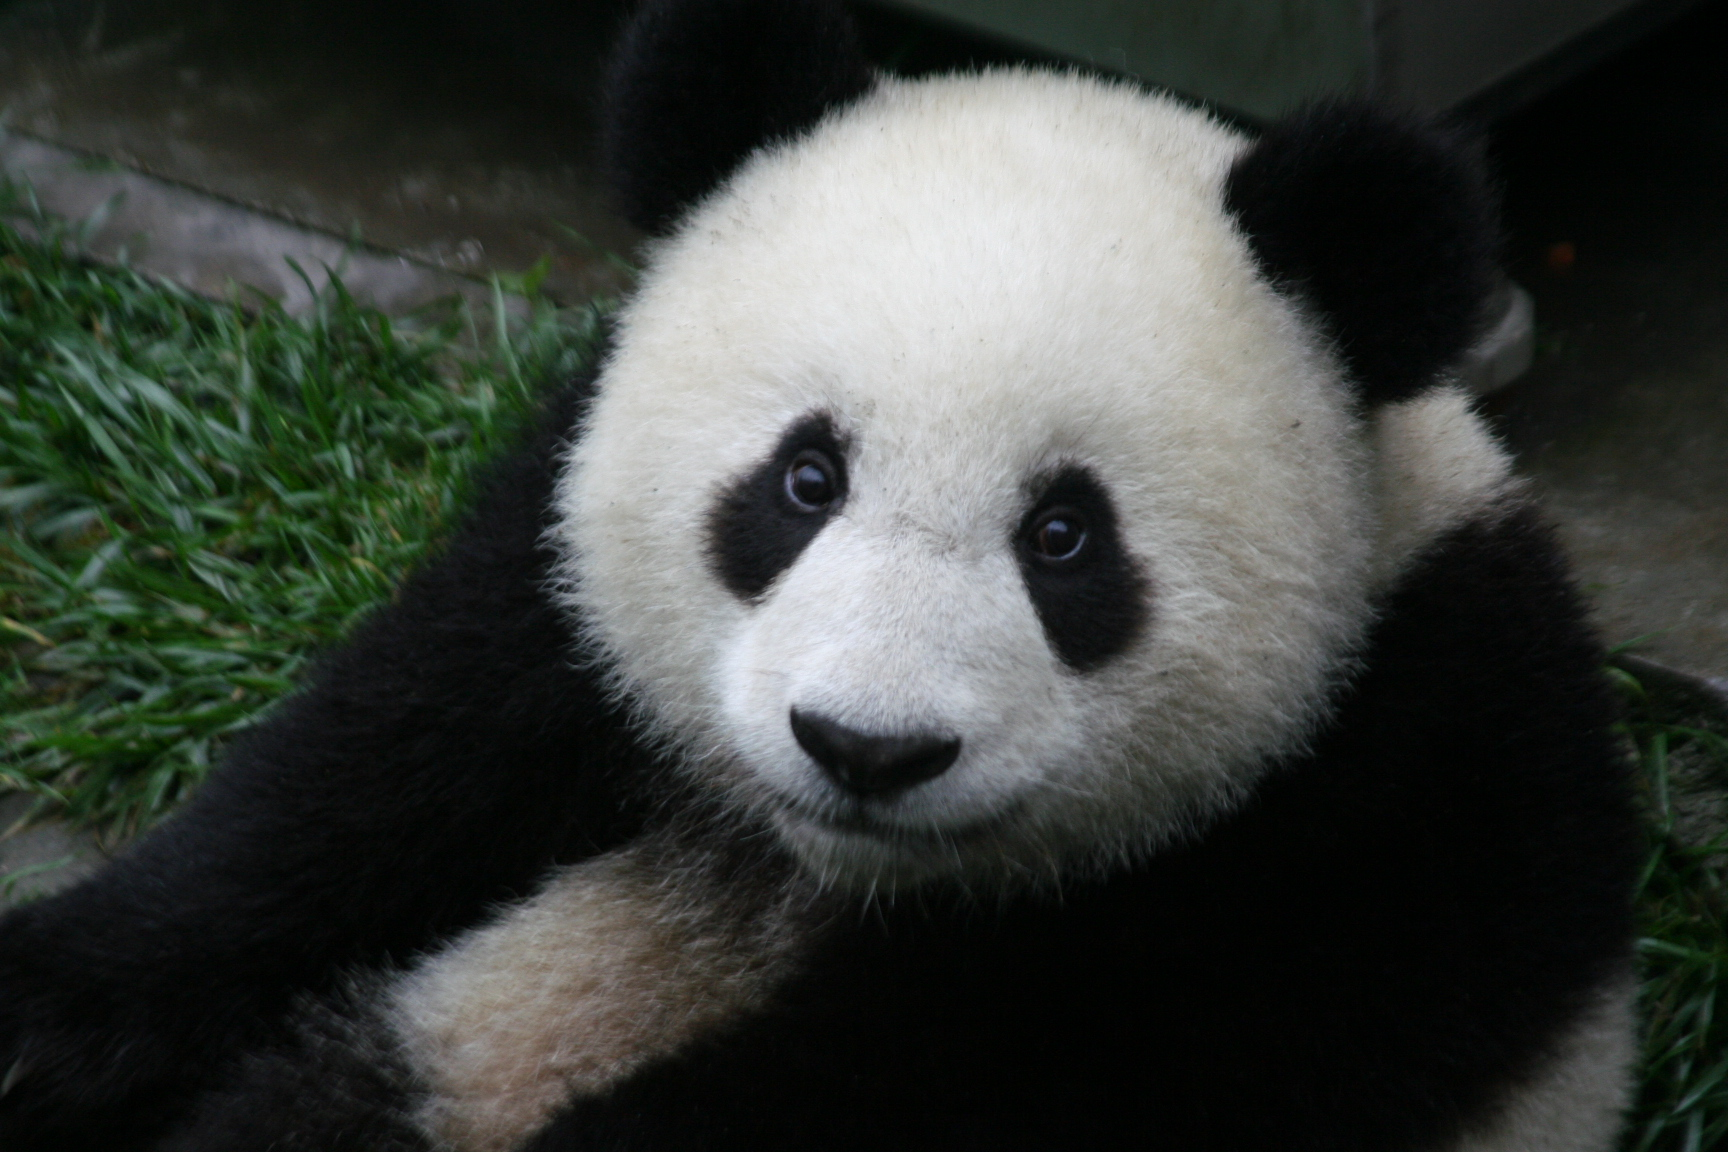

In [2]:
from PIL import Image
import requests
from io import BytesIO

def fetch_img(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content))

# load image
url = 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg'
raw_img = fetch_img(url)
raw_img

In [3]:
from PIL import Image
from torchvision import transforms

# preprocess image before inference
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
input_tensor = preprocess(raw_img)
input_batch = input_tensor.unsqueeze(0).cuda()

# inference
output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [4]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

giant panda 0.9963906407356262
badger 0.0009602984064258635
lesser panda 0.00043532278505153954
gibbon 0.0004057540209032595
indri 0.00033056948450393975


## Integrated Gradients

The formula for Integrated Gradients is as follows:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature (individual pixel)  
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$\alpha$ = interpolation constant

In practice, computing a definite integral can be computationally expensive, so we calculate the following approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$k$ = interpolation constant step  
$m$ = number of steps in the Riemann sum approximation of the integral 

Breaking the equation down into parts, here are the steps we must follow to calculate the integrated gradients:

$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

### 1. Generate alphas 

In [5]:
# Preprocess image and create baseline image
resize = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])
image = resize(raw_img)
baseline = np.zeros((224, 224, 3))

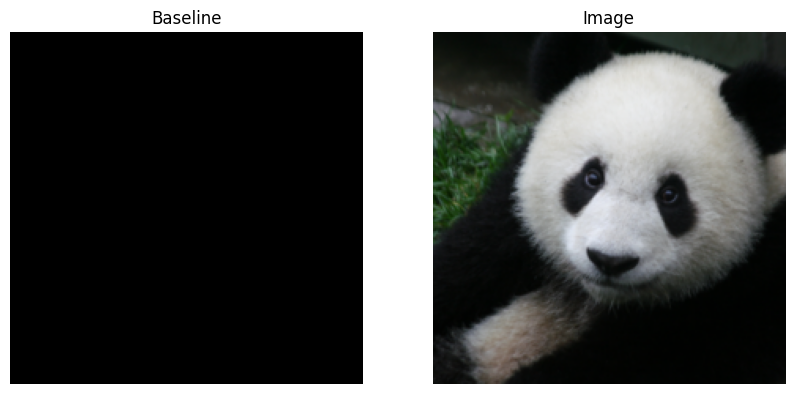

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot baseline and image
axs[0].imshow(baseline)
axs[1].imshow(image)

axs[0].set_title("Baseline")
axs[1].set_title("Image")

axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [7]:
# Generate alphas
m_steps = 50 # number of steps in Riemann approximation of the integral
alphas = np.linspace(0.0, 1.0, m_steps+1)
print(alphas)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


### 2. Interpolate Images

$(x' + \frac{k}{m}\times(x - x'))$

where:  
$x$  = image  
$x'$ = baseline  
$\frac{k}{m}$ = alphas

In [8]:
def interpolate_images(baseline, image, alphas):
  alphas_x = alphas[:, np.newaxis, np.newaxis, np.newaxis]
  baseline_x = baseline[np.newaxis, :]
  input_x = image[np.newaxis, :]
  delta = input_x - baseline_x
  images = baseline_x + alphas_x * delta

  return images

In [9]:
interpolated_imgs = interpolate_images(baseline, np.array(image), alphas)

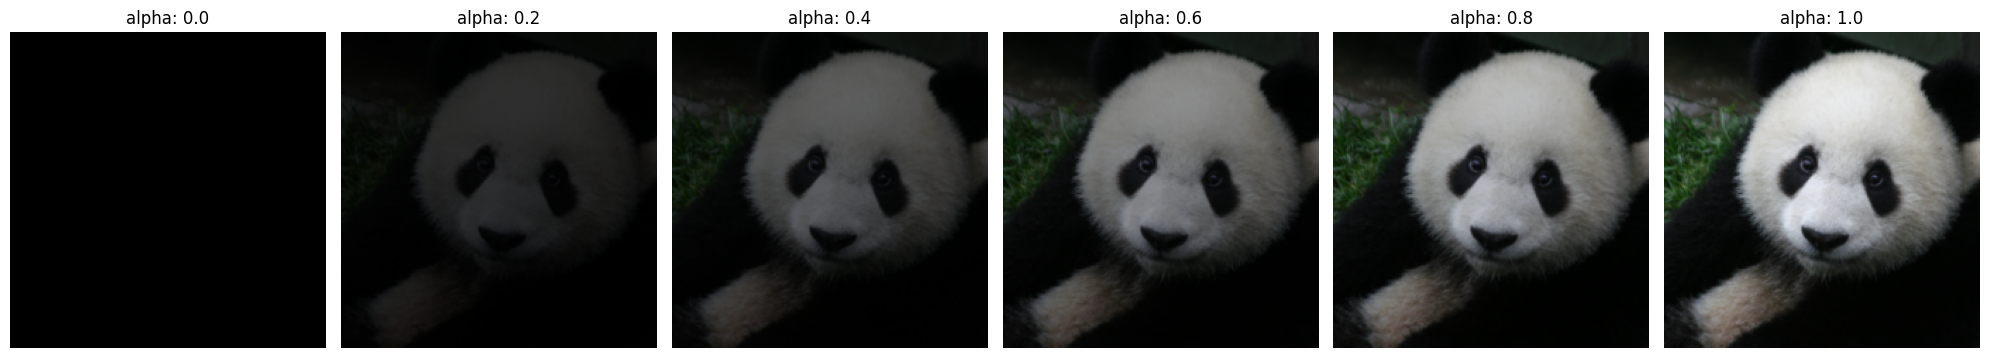

In [10]:
# Plotting some interpolated images

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_imgs[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  image = image.astype(np.uint8)
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()

### 3. Compute gradients between model outputs and interpolated images = $\frac{\partial F(\text{interpolated images})}{\partial x_{i}}$

In [11]:
# Before we feed the model with the images we need to normalize them
normalize = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
normalized_imgs = [normalize(img.astype(np.uint8)) for img in interpolated_imgs]

In [12]:
# Stack the images into a tensor and move it to the GPU
interpolated_imgs = torch.stack(normalized_imgs).cuda()
print(interpolated_imgs.shape)

torch.Size([51, 3, 224, 224])


In [13]:
def compute_gradients(images, target_class_idx):
  # We must set required_grad to True, so we can track the gradients
  if images.requires_grad is False: images.requires_grad = True
  # Inference
  logits = model(images)
  # Get the probabilites of the given target class
  probs = torch.nn.functional.softmax(logits, dim=-1)[:, target_class_idx]
  # Compute the gradients of the input with the respect of the target class prob
  grads = torch.autograd.grad(outputs=probs, inputs=images, grad_outputs=torch.ones_like(probs))[0]
  return grads, probs

In [14]:
# In this case the 'Giant Panda' class index is 388
gradient_batch, probs = compute_gradients(images=interpolated_imgs[0::10], target_class_idx=388)
print(gradient_batch.shape)

torch.Size([6, 3, 224, 224])


#### Visualizing gradient saturation

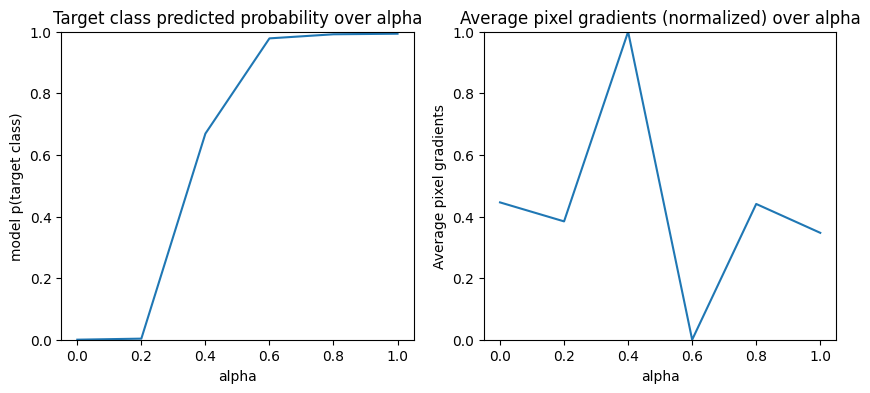

In [15]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas[0::10], probs.detach().cpu().numpy())
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = torch.mean(gradient_batch.detach().cpu(), dim=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads - torch.min(average_grads)) / (torch.max(average_grads) - torch.min(average_grads))
ax2.plot(alphas[0::10], average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

### 4. Integral Approximation  $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

In [16]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / torch.tensor(2.0)
  integrated_gradients = torch.mean(grads, dim=0)
  return integrated_gradients

In [17]:
avg_gradients = integral_approximation(gradients=gradient_batch)

In [18]:
# Permute to (H, W, C) and move to cpu
avg_gradients = avg_gradients.permute(1, 2, 0).cpu()

### 5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$

In [19]:
ig = (np.array(image) - baseline) * avg_gradients.detach().numpy()

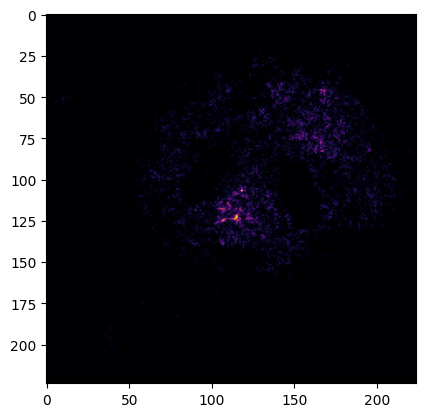

In [20]:
# Show results
attribution_mask = np.sum(np.abs(ig), axis=-1)
plt.imshow(np.uint8(attribution_mask), cmap=plt.cm.inferno)

### Putting it all together

In [21]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=10):

  normalize = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])

  # 1. Generate alphas
  alphas = np.linspace(0.0, 1.0, m_steps+1)

  # Collect gradients
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in range(0, len(alphas), batch_size):
    from_ = alpha
    to = min(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input
    interpolated_imgs = interpolate_images(baseline, np.array(image), alpha_batch)
    # convert ndarray images to torch.tensors and stack them
    interpolated_imgs = torch.stack([normalize(img.astype(np.uint8)) for img in interpolated_imgs]).cuda()
    #print(interpolated_imgs.shape)

    # 3. Compute gradients between model outputs and interpolated inputs
    gradient_batch = compute_gradients(images=interpolated_imgs,
                                      target_class_idx=target_class_idx)[0]
    gradient_batches.append(gradient_batch.cpu())

  # Stack path gradients together row-wise into single tensor.
  total_gradients = torch.cat(gradient_batches, dim=0).cuda()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # permute to (H, W, C) and move to cpu
  avg_gradients = avg_gradients.permute(1, 2, 0).detach().cpu().numpy()

  # Scale integrated gradients with respect to input.
  ig = (np.array(image) - baseline) * avg_gradients

  return ig

In [22]:
def show_ig_results(image, ig):
  attribution_mask = np.sum(np.abs(ig), axis=-1)
  # show results
  fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(8, 8))
  axs = axs[0]
  cmap = plt.cm.inferno

  axs[0].set_title('Original image')
  axs[0].imshow(image)
  axs[0].axis('off')

  axs[1].set_title('Attribution mask')
  axs[1].imshow(attribution_mask, cmap=cmap)
  axs[1].axis('off')

  axs[2].set_title('Overlay')
  axs[2].imshow(attribution_mask, cmap=cmap)
  axs[2].imshow(image, alpha=0.4)
  axs[2].axis('off')

  plt.tight_layout()
  plt.show()


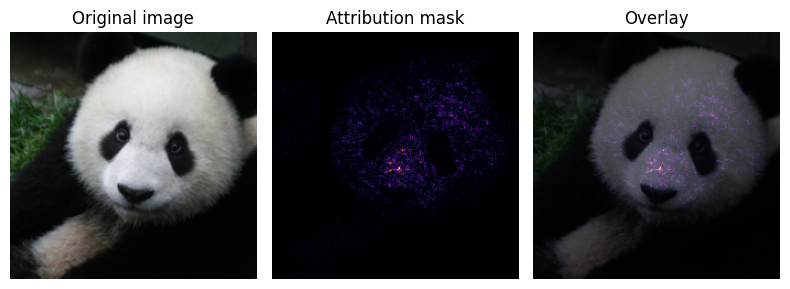

In [23]:
# Giant Panda
m_steps = 256
batch_size = 16
target_class_idx = 388
giant_panda_img = image
# compute
ig = integrated_gradients(baseline=baseline, image=giant_panda_img, m_steps=m_steps, batch_size=batch_size, target_class_idx=target_class_idx)
# show results
show_ig_results(giant_panda_img, ig)

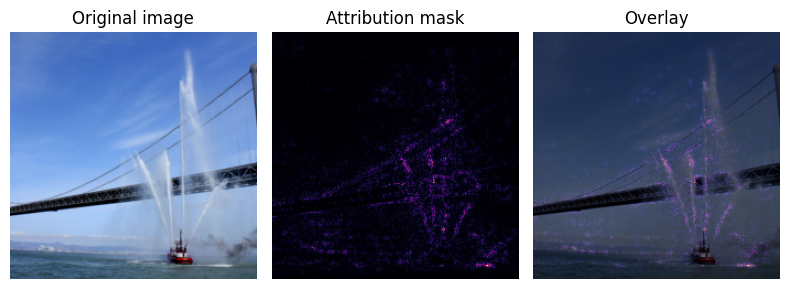

In [24]:
# Fireboat
m_steps = 256
batch_size = 16
target_class_idx = 817
fireboat_img = fetch_img('http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg')
fireboat_img = resize(fireboat_img)
# compute
ig = integrated_gradients(baseline=baseline, image=fireboat_img, m_steps=m_steps, batch_size=batch_size, target_class_idx=target_class_idx)
# show results
show_ig_results(fireboat_img, ig)